<center><h1 style="color:#173F8A;"> Metodos para Ecuaciones Diferenciales, IMT3410, 2024-2 </h1></center>
<h3 style="color:#173F8A;text-align:right;"> Instituto de Ingenieria Matematica y Computacional<br>  Pontificia Universidad Catolica de Chile <br>  </h3>
<h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br> </h3>
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC: celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 -->
<!--
<figure>
<img align ="right" src="IMClogo.png" alt="logo" width="250" height="400"><br><br><br><br><br>
</figure>
 -->

## Finite Element Methods for Ordinary Differential Equations 

<h2 style="color:#03122E;text-align:center;"> Capitulo 1. Metodos para Ecuaciones Diferenciales Ordinarias<br> </h2>
<hr style="border:3px solid #E3AE00 "> </hr>

## **Temas**
1. [Regla de cuadratura de Gauss Legendre](#Regla-de-cuadratura-de-Gauss-Legendre)
2. [Triangulacion de elementos finitos](#Triangulacion-de-elementos-finitos)
3. [Base polinomial de Lagrange](#Base-polinomial-de-Lagrange)
4. [Solver para EDO usando FEM - caso lineal](#Solver-para-EDO-usando-FEM-caso-lineal)
5. [Solver para EDO usando FEM - caso no lineal](#Solver-para-EDO-usando-FEM-caso-no-lineal)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from scipy.special import binom
from scipy.linalg import lu_factor, lu_solve
from IPython.display import display, HTML
display(HTML("""<style>.output {display: flex;align-items: center;text-align: center;}</style>"""))

## Regla de cuadratura de Gauss Legendre
$$
\int_{a}^{b} f(x) dx \approx \left(\frac{b-a}{2}\right)\sum_{i=1}^{n} w_{j} f(x_{j})
$$
Integra polinomios de orden $2n-1$ o menor exactamente

In [57]:
# Quadrature Gauss-Legendre
def quad_Gauss_Legendre(fun, a=-1,b=1, n=6):
    theta, w = leggauss(n)
    sum = 0; h = 0.5*(b-a); m = 0.5*(a+b)
    for k in range(len(theta)):
        sum += w[k]*fun(m+theta[k]*h)
    return h*sum

## Ejemplos: Approximar las siguientes integrales
- $\displaystyle \int_{0}^{1} x^{7} dx $
- $\displaystyle \int_{-1.5}^{1} \pi\sin(2\pi x) dx$
- $\displaystyle \int_{0}^{1} (1-x)^{4}x^{3} dx $

In [65]:
# Example 1:
M = 7
f_ex1 = lambda x: x**M
quad_ex1 = quad_Gauss_Legendre(f_ex1, a=0, b=1, n=4)
err_ex1 = abs(1.0/(M+1) - quad_ex1)

# Example 2:
f_ex2 = lambda x: np.pi*np.sin(2*np.pi*x)
quad_ex2 = quad_Gauss_Legendre(f_ex2, a=-1.5, b=1,n=8)
err_ex2 = abs(-1.0-quad_ex2)


# Example 3:
f_ex3 = lambda x: (1.0-x)**4 * x**3
quad_ex3 = quad_Gauss_Legendre(f_ex3, a=0, b=1,n=4)
err_ex3 = abs(1.0/280.0-quad_ex3)

print(f"error 1: {err_ex1}, error 2: {err_ex2}, , error 3: {err_ex3}")

error 1: 9.71445146547012e-17, error 2: 0.00076412574561735, , error 3: 8.673617379884035e-19


## Triangulacion de elementos finitos

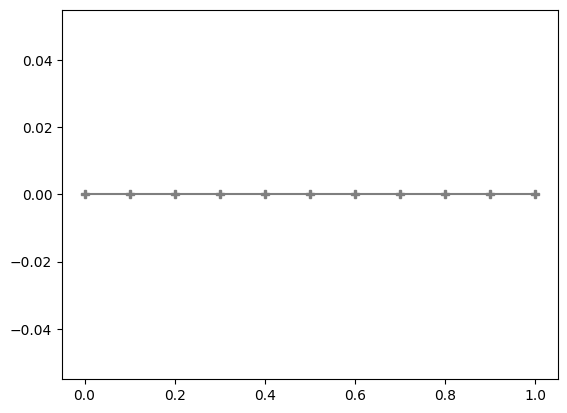

In [4]:
N = 10
Coordinates = np.linspace(0,1,N+1)
Elements = np.asarray([[i,i+1] for i in range(N)])
plt.plot(Coordinates, np.zeros(N+1), 'P-',markersize=6, color='C07')
plt.show()

## Base polinomial de Lagrange

In [83]:
def Lagrangebasis(t,n,j, interval=(0.0,1.0)):
    a,b = interval
    nodes = np.linspace(a, b, n+1)

    L_j = 1.0
    for m in range(n + 1):
        if m != j:
            L_j *= (t - nodes[m]) / (nodes[j] - nodes[m])
    return L_j
def derivativeLagrangebasis(t,n,j,interval=(0.0,1.0)):
    a,b = interval
    nodes = np.linspace(a, b, n+1)
    
    dL_j_dt = 0.0
    for m in range(n + 1):
        if m != j:
            term = 1.0
            for k in range(n + 1):
                if k != j and k != m:
                    term *= (t - nodes[k]) / (nodes[j] - nodes[k])
            dL_j_dt += term / (nodes[j] - nodes[m])
    return dL_j_dt

def LagrangeInterpolant(t, ci, interval):
    n = len(ci)-1
    return sum([ci[j]*Lagrangebasis(t,n,j,interval) for j in range(n+1)])

def plot_Lagrangebasis_interval(n=6, interval=(0,1), ax=None, color=None):    
    a,b = interval
    tt = np.linspace(a,b,100)
    if ax is None:
        fig, ax = plt.subplots()
    for j in range(n+1):
        ax.plot(tt, Lagrangebasis(tt,n,j, [a,b]), color=color, label="L%i" %j)
    ax.plot(np.linspace(a,b,n+1), np.zeros(n+1), 'P-',markersize=6, color='black')
    plt.legend()
    ax.set_title('Lagrange polynomials of degree %i'%n)

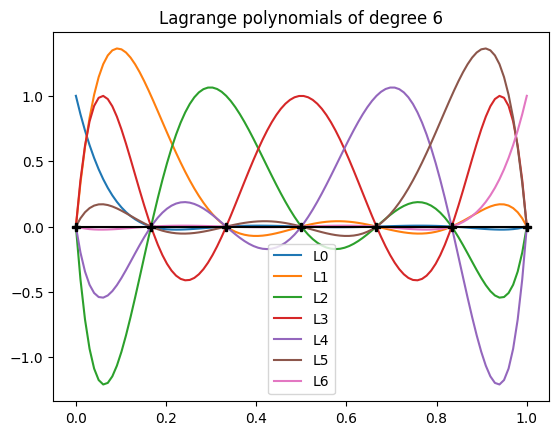

In [84]:
plot_Lagrangebasis_interval(n=6)

## Solver para EDO usando FEM caso lineal

### Calculo de la matriz usando la base de Lagrange
 
 Queremos calcular 
 \begin{equation}
 \int_{I_j} \varphi_{i}'(x) \varphi_{k}(x) dx = \int_{I_{j}} (L_{j}^{(n)}(x))' L_{k}^{(n)}(x) dx 
 \end{equation}
 donde 
 $$L_{i}^{(n)} = \prod_{0\leq i\leq n, i\neq j} \frac{t-t_{i}}{t_{j}-t_{i}}$$
 y la derivada de estos
\begin{equation}
\left( L_i^{(n)}(x)\right)' = 
\sum_{0\leq i\leq n, i\neq j} \frac{1}{t-t_{i}} L_{j}^{(n)}
\end{equation}

Podemos calcular la integral de esto con una regla de cuadratura Gauss Legendre de $n$ puntos 
\begin{equation}
\int_{I_{j}} (L_{j}^{(n)}(x))' L_{k}^{(n)}(x) dx  = \left(\frac{t_{i}-t_{i+1}}{2}\right)\sum_{j=1}^{n} w_{j} (L_{j}^{(n)})'(x_{j})  (L_{j}^{(n)}(x_j))
\end{equation}

In [ ]:
def compute_convectionmatrix(n, interval):
    a,b = interval
    A = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(n + 1):
            integrand = lambda t: derivativeLagrangebasis(t,n,j,interval) * Lagrangebasis(t,n,i,interval)
            A[i, j] = quad(integrand, a, b)[0]
    return A

## Solver caso lineal
Asumimos primero que $f(t,u) = f(t)$, asi nos queda un sistema lineal a resolver

In [108]:
def fem_odesolver_linear(Coordinates, Elements, f, u0, n): 
    # Resuelve secuencialmente por elemento
    N = Elements.shape[0] # numero de elementos
    uleft = u0
    usol = []
    for i in range(N): # interacion sobre los intervalos
        # matriz local
        ta = Coordinates[Elements[i,0]]; tb = Coordinates[Elements[i,1]]
        AK = compute_matrix(n, (ta, tb))
        AK[0,:] = 0
        AK[0,0] = 1.0

        # vector derecho local
        cK = np.zeros(n+1, dtype=np.float64)
        cK[0] = uleft
        for k in range(1,n+1):                              
            integrand = lambda t: f(t)*Lagrangebasis(t,n,k,(ta,tb))
            cK[k] = quad_Gauss_Legendre(integrand,ta,tb,n+1)
        # Resolver el sistema local
#         print(f"AK :{AK}")
#         print(f"cK:{cK}")
        usolK = np.linalg.solve(AK,cK)
#         print(f"usolK: {usolK}")
        usol.append(usolK)
        uleft = usolK[n]
    return usol
def plot_piecewise_poly(usol, n, Coordinates, Elements, ax=None):
    N = Elements.shape[0]
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(Coordinates, np.zeros(N+1), 'P-',markersize=8, color='C07', linewidth=2)
    for i in range(N):
        ta = Coordinates[Elements[i,0]]
        tb = Coordinates[Elements[i,1]]
        ci = usol[i]
        ui = lambda t: LagrangeInterpolant(t, ci, (ta,tb))
        tti = np.linspace(ta,tb,8)
        ax.plot(tti, ui(tti), 'C00')
    plt.legend(['triang.','solucion aprox.'])
    return fig,ax

### Ejemplo
- Consideramos $ f(t) = 1$, con $u_0 = 1.0$. Asi la solucion exacta es $u(t) = 1+t$.
- Consideramos $ f(t) = t$, con $u_0 = 1.0$. Asi la solucion exacta es $u(t) = 1+t^{2}/2$.
- Consideramos $f(t) = -2\pi\sin(2\pi t)$, con $u_0=1$. Asi la solucion exacta es $u(t) = \cos(2\pi t)$.

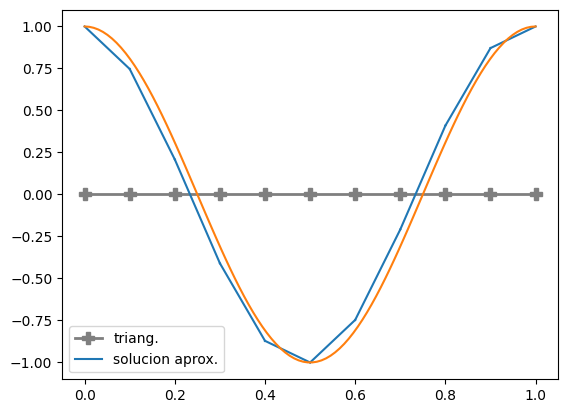

In [110]:
# Tringulacion
N = 10
Coordinates = np.linspace(0,1,N+1); Elements = np.asarray([[i,i+1] for i in range(N)])

# Datos del problema 1
# f = lambda t: 1.0; u0 = 1.0; uexact = lambda t:  t+1.0

# Datos del problema 2
# f = lambda t: t  ; u0 = 1.0; uexact = lambda t: 0.5*t**2 + 1.0

# Datos del problema 3
f = lambda t: -(2.0*np.pi)*np.sin(2*np.pi*t); u0=1.0; uexact = lambda t: np.cos(2*np.pi*t)

## Resolver
n = 1 # grado polinomial de la aproximacion
usol = fem_odesolver_linear(Coordinates, Elements, f, u0, n=n)

# Plot
fig, ax = plot_piecewise_poly(usol, n, Coordinates, Elements)
tt = np.linspace(0,1,100)
ax.plot(tt, uexact(tt), 'C01')
plt.show()

##  Solver para EDO usando FEM caso no lineal

In [111]:
MAXITER = 100
TOL =1e-8
def fem_odesolver_nonlinear(Coordinates, Elements, f, u0, n): 
    # Resuelve secuencialmente por elemento
    N = Elements.shape[0] # numero de elementos
    uleft = u0
    usol = []
    for i in range(N): # interacion sobre los intervalos
        # matriz local
        ta = Coordinates[Elements[i,0]]; tb = Coordinates[Elements[i,1]]
        hj = abs(tb-ta)
        AK = compute_matrix(n, (ta, tb))
        AK[0,:] = 0
        AK[0,0] = 1.0
        lu, piv = lu_factor(AK)

        # vector derecho local
        cK = np.zeros(n+1, dtype=np.float64)
        cK[0] = uleft
        
        # Fix point iteration 
        usolKnew = uleft*np.ones(n+1); error=1.0; iter = 0
        while iter <MAXITER and error>TOL:
            usolK = usolKnew
            uK = lambda t: LagrangeInterpolant(t, usolK, (ta,tb))
            for k in range(1,n+1):
                integrand = lambda t: f(t, uK(t))*Lagrangebasis(t,n,k,(ta,tb))
                cK[k] = quad_Gauss_Legendre(integrand,ta,tb,n)
            # Resolver el sistema local
            usolKnew = lu_solve((lu, piv), cK)
            error = np.linalg.norm(usolKnew - usolK)
            iter +=1
        usol.append(usolK)
        uleft = usolK[n]
    return usol

## Ejemplo 2: caso no lineal
$$ u'(t) = f(t,u(t)) = -2t u^{2}, \quad u(0) =  1 $$

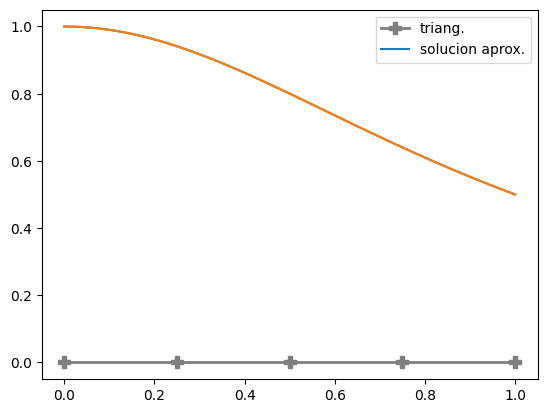

In [113]:
# Triangulacion
N = 4
Coordinates = np.linspace(0,1,N+1); Elements = np.asarray([[i,i+1] for i in range(N)])
# Datos del problema no lineal
fnonlinear = lambda t,u: -2*t*u**2; u0 = 1.0; uexact = lambda t: 1.0/(1+t**2)

#
n = 4
usol = fem_odesolver_nonlinear(Coordinates, Elements, fnonlinear, u0, n=n)


fig,ax = plot_piecewise_poly(usol, n, Coordinates, Elements)
tt = np.linspace(0,1,100)

ax.plot(tt, uexact(tt), 'C01')
plt.show()

---

## Base polinomial de Bernstein

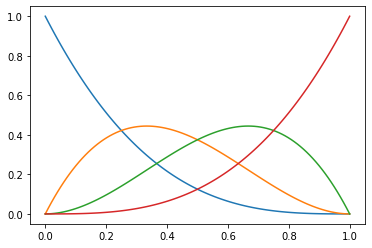

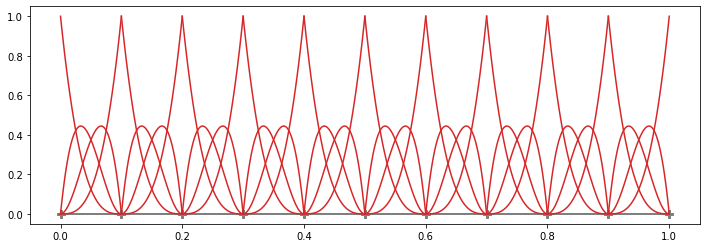

In [10]:
# Bernstein-Bezier Basis in 1D on the interval [a,b]
def Bernsteinbasis(t,n,j,interval = (0.0,1.0)):
    a,b = interval
    lambda1 = -(t-b)/(b-a)
    lambda2 = (t-a)/(b-a)
    return binom(n,j)*lambda1**(n-j)*lambda2**j

def derivativeBernsteinbasis(t,n,j,interval=(0.0,1.0)):
    a,b = interval
    lambda1 = -(t-b)/(b-a); lambda2 = (t-a)/(b-a)
    dlambda1 = -1/(b-a); dlambda2 = 1/(b-a)
    if j == 0:
        return (n)*lambda1**(n-1)*dlambda1
    elif n==j:
        return (n)*lambda2**(n-1)*dlambda2
    else: 
        return binom(n,j)*((n-j)*lambda1**(n-j-1)*lambda2**j*dlambda1 + j*lambda1**(n-j)*lambda2**(j-1)*dlambda2) 

def BernsteinInterp(t, ci, interval):
    # implement this usin deCasteljau
    n = len(ci)-1
    return sum([ci[j]*Bernsteinbasis(t,n,j,interval= interval) for j in range(n+1)])

def plotbasis_interval(n=6, interval=(0,1), ax=None, color=None):    
    a,b = interval
    tt = np.linspace(a,b,100)
    if ax is None:
        fig, ax = plt.subplots()
    for j in range(n+1):
        ax.plot(tt, Bernsteinbasis(tt,n,j, [a,b]), color=color)

def plotbasis_global(n, Coordinates, Elements):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
    ax.plot(Coordinates, np.zeros(N+1), 'P-',markersize=8, color='C07', linewidth=2)
    for j in range(Elements.shape[0]):
        a = Coordinates[Elements[j,0]]
        b = Coordinates[Elements[j,1]]
        plotbasis_interval(n=n, interval=(a,b), ax=ax, color='C03')
plotbasis_interval(n=3)
plotbasis_global(n=3, Coordinates=Coordinates, Elements=Elements)

### Pregunta: Cual es el numero de grados de libertad o tamano del sistema?

## Solver para EDO usando FEM - lineal

### Calculo de la matriz usando la base de Bernstein
 
 Queremos calcular 
 \begin{equation}
 \int_{I_j} \varphi_{i}'(x) \varphi_{k}(x) dx = \int_{I_{j}} (B_{j}^{n}(x))' B_{k}(x) dx 
 \end{equation}
 donde $B_{i}^{n} = {n\choose i} \lambda_{1}^{n-i}(x) \lambda_{2}^{i}(x)$, con $\lambda_1(x) = -(x-b)/h$ y $\lambda_2(x) = (x-a)/h$, y
 \begin{equation}
\left( B_i^{n}(x)\right)' = \frac{n}{|I_j|} \left(B_{i-1}^{n-1}(x) - B_{i}^{n-1}(x) \right) \end{equation}

Ademas tenemos la propiedad del producto e integral de polinomios de Bernstein
\begin{equation}
B_{i}^{n}(x) B_{j}^{m}(x) = \frac{{n \choose i}{m \choose j}}{{n+m \choose i+j}}B_{i+j}^{n+m}(x)
\end{equation}
\begin{equation}
\int_{I_j}B_i^{n}(x)dx = \frac{|I_j|}{n+1}
\end{equation}

Asi podemos calcular

\begin{equation}
\int_{I_j} \left( B_i^{n}(x)\right)' B_{k}^{n}(x) dx  = 
\begin{cases}
-\frac{1}{2}\frac{{n \choose k}}{{2n-1\choose k}} & \text{si }i =0  \\
 \frac{1}{2}\frac{{n \choose k}{n-1\choose i}}{{2n-1\choose i+k}}\left(\frac{n(i-k)}{(n-i)(i+k)} \right)& \text{si } 1\leq i\leq n-1 \\
\frac{1}{2} \frac{{n \choose k}}{{2n-1 \choose n-1+k}} & \text{si } i=n
\end{cases}
\end{equation}

In [11]:
def int_dB_B(n,i,k):
    # Computes integral_{I_j} (B_i^n)'(b_k^n) dx
    if i == 0:
        return -0.5*binom(n,k)/binom(2*n-1,k) 
    elif i == n:
        return 0.5*binom(n,k)/binom(2*n-1,n-1+k)
    else:
        return 0.5*binom(n,k)*binom(n-1,i)/binom(2*n-1,i+k)*(n*(i-k)/((n-i)*(i+k))) 

## Solver para el caso $f = f(t)$ independiente de $u$

In [24]:
def fem_odesolver_linear(Coordinates, Elements, f, u0, n): # Resuelve secuencialmente por elemento
    N = Elements.shape[0] # numero de elementos
    uleft = u0
    usol = []
    for i in range(N): # interacion sobre los intervalos
        # matriz local
        ta = Coordinates[Elements[i,0]]; tb = Coordinates[Elements[i,1]]
        AK = np.zeros((n+1,n+1), dtype=np.float64)
        AK[0,0] = 1.0
        for k in range(1, n+1):
            for j in range(n+1):
                AK[k,j] = int_dB_B(n,j,k)
        # vector derecho local
        cK = np.zeros(n+1, dtype=np.float64)
        cK[0] = uleft
        for k in range(1,n+1):
            phik = lambda t: Bernsteinbasis(t,n,k,[ta,tb])                                      
            func = lambda t: f(t)*phik(t)
            cK[k] = quad_Gauss_Legendre(func,ta,tb,n)
        # Resolver el sistema local
        print(f"AK :{AK}")
        print(f"cK:{cK}")
        usolK = np.linalg.solve(AK,cK)
        print(f"usolK: {usolK}")
        usol.append(usolK)
        uleft = usolK[n]
    return usol
def plot_piecewise_poly(usol, n, Coordinates, Elements, ax=None):
    N = Elements.shape[0]
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(Coordinates, np.zeros(N+1), 'P-',markersize=8, color='C07', linewidth=2)
    for i in range(N):
        ta = Coordinates[Elements[i,0]]
        tb = Coordinates[Elements[i,1]]
        ci = usol[i]
        ui = lambda t: BernsteinInterp(t, ci, [ta,tb])
        tti = np.linspace(ta,tb,5)
        ax.plot(tti, ui(tti), 'C00')
    plt.legend(['triang.','solucion aprox.'])
    return fig,ax

## Ejemplo 1: caso lineal 
$$u'(t) = f(t, u(t)) = t,\quad u(0) = 1$$

AK :[[ 1.          0.          0.          0.          0.          0.
   0.        ]
 [-0.27272727  0.          0.09090909  0.09090909  0.05844156  0.02597403
   0.00649351]
 [-0.13636364 -0.09090909  0.          0.06493506  0.08116883  0.05844156
   0.02272727]
 [-0.06060606 -0.09090909 -0.06493506  0.          0.06493506  0.09090909
   0.06060606]
 [-0.02272727 -0.05844156 -0.08116883 -0.06493506  0.          0.09090909
   0.13636364]
 [-0.00649351 -0.02597403 -0.05844156 -0.09090909 -0.09090909  0.
   0.27272727]
 [-0.00108225 -0.00649351 -0.02272727 -0.06060606 -0.13636364 -0.27272727
   0.5       ]]
cK:[1.         0.00892857 0.01339286 0.01785714 0.02232143 0.02678571
 0.03125   ]
usolK: [1.         1.         1.00833333 1.025      1.05       1.08333333
 1.125     ]
AK :[[ 1.          0.          0.          0.          0.          0.
   0.        ]
 [-0.27272727  0.          0.09090909  0.09090909  0.05844156  0.02597403
   0.00649351]
 [-0.13636364 -0.09090909  0.          0.064

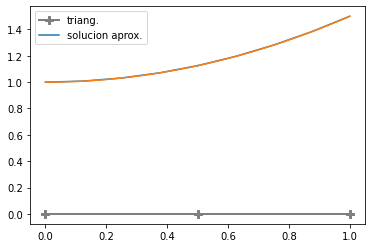

In [26]:
# Tringulacion
N = 2
Coordinates = np.linspace(0,1,N+1)
Elements = np.asarray([[i,i+1] for i in range(N)])
# Datos del problema
f = lambda t: t
uexact = lambda t: 0.5*t**2 + 1.0
# initial condition # y' = t y(0)=1 ==> y= t^2/2+1
u0 = 1.0
# Resolver
n = 6
usol = fem_odesolver_linear(Coordinates, Elements, f, u0, n=n)
fig, ax = plot_piecewise_poly(usol, n, Coordinates, Elements)
tt = np.linspace(0,1,100)
ax.plot(tt, uexact(tt), 'C01')
plt.show()

### Solver para el problema no lineal, $f$ depende de $u(t)$

In [14]:
MAXITER = 100
TOL =1e-8
def fem_odesolver_nonlinear(Coordinates, Elements, f, u0, n): # Resuelve secuencialmente por elemento
    N = Elements.shape[0] # numero de elementos
    uleft = u0
    usol = []
    for i in range(N): # interacion sobre los intervalos
        # matriz local
        ta = Coordinates[Elements[i,0]]; tb = Coordinates[Elements[i,1]]
        hj = abs(tb-ta)
        AK = np.zeros((n+1,n+1), dtype=np.float64)
        AK[0,0] = 1.0
        for k in range(1, n+1):
            for j in range(n+1):
                AK[k,j] = int_dB_B(n,j,k)
        lu, piv = lu_factor(AK)

        # vector derecho local
        cK = np.zeros(n+1, dtype=np.float64)
        cK[0] = uleft
        
        # Fix point iteration 
        usolKnew = uleft*np.ones(n+1); error=1.0; iter = 0
        while iter <MAXITER and error>TOL:
            usolK = usolKnew
            uK = lambda t: BernsteinInterp(t, usolK, [ta,tb])
            for k in range(1,n+1):
                phik = lambda t: Bernsteinbasis(t,n,k,[ta,tb])
                func = lambda t: f(t, uK(t))*phik(t)
                cK[k] = quad_Gauss_Legendre(func,ta,tb,n)
            # Resolver el sistema local
#             usolKnew = np.linalg.solve(AK,cK)
            usolKnew = lu_solve((lu, piv), cK)
            error = np.linalg.norm(usolKnew - usolK)
            iter +=1
        usol.append(usolK)
        uleft = usolK[n]
    return usol

In [19]:
# Triangulacion
N = 4
Coordinates = np.linspace(0,1,N+1)
Elements = np.asarray([[i,i+1] for i in range(N)])
# Datos del problema
fnonlinear = lambda t,u: -2*t*u**2
# initial condition # y' = -2ty^2, y(0)=1 ==> y= 1/(1+t^2)
u0 = 1.0
n=3
usol = fem_odesolver_nonlinear(Coordinates, Elements, fnonlinear, u0, n=n)
print(usol)

[array([1.        , 1.00022121, 0.97826183, 0.94117653]), array([0.94117653, 0.90425473, 0.85327185, 0.80000012]), array([0.80000012, 0.7465644 , 0.6910915 , 0.6400001 ]), array([0.6400001 , 0.58873992, 0.54161303, 0.50000007])]


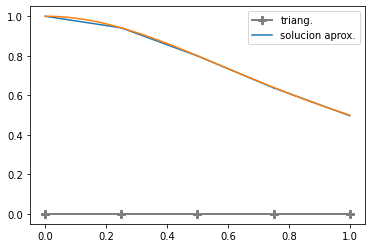

In [18]:
fig,ax = plot_piecewise_poly(usol, n, Coordinates, Elements)
tt = np.linspace(0,1,100)
uexact = lambda t: 1.0/(1+t**2)
ax.plot(tt, uexact(tt), 'C01')
plt.show()